In [10]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [11]:
df = pd.read_csv('feature_selection_top_states.csv', index_col = 'Date', parse_dates = True)
df.head()

,Unnamed: 0,contact_tracing,debt_relief,restrictions_on_internal_movement,current_intensive_care_patients,facial_coverings,public_information_campaigns,testing_policy,income_support,public_transport_closing,...,NATIVE_PEOPLES,booster_rate,vaccination_policy,maximum_temperature_celsius,prop_age85plus,prop_age6064,prop_age8084,vaccination_rate_1dose,PEOPLE_POSITIVE_NEW_CASES_COUNT,PROVINCE_STATE_NAME
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-01,0,1.0,1.0,0.5,112.5,0.5,1.5,2.0,0.0,0.0,...,873999,0.0,2.5,26.848765,1.860398,5.818187,1.71647,0.0,5,California
2020-03-02,1,1.0,1.0,0.5,112.5,0.5,1.5,2.0,0.0,0.0,...,873999,0.0,2.5,26.848765,1.860398,5.818187,1.71647,0.0,5,California
2020-03-03,2,1.0,1.0,0.5,112.5,0.5,1.5,2.0,0.0,0.0,...,873999,0.0,2.5,26.848765,1.860398,5.818187,1.71647,0.0,7,California
2020-03-04,3,1.0,1.0,0.0,112.5,0.0,1.0,1.0,0.0,0.0,...,873999,0.0,0.0,24.685185,1.860398,5.818187,1.71647,0.0,10,California
2020-03-05,4,1.0,1.0,0.0,112.5,0.0,1.0,1.0,1.0,0.0,...,873999,0.0,0.0,25.753086,1.860398,5.818187,1.71647,0.0,12,California


In [12]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [13]:
df.shape

(7900, 52)

In [14]:
ca_df = df[df['PROVINCE_STATE_NAME'] == 'California']
ca_df.shape

(790, 52)

In [15]:
ca_df.drop(columns = ['PROVINCE_STATE_NAME'], inplace = True)
ca_df.shape

(790, 51)

In [16]:
#separate train & test sets
train_size = int(len(ca_df)* 0.85)
ca_train, ca_test = ca_df[0:train_size], ca_df[train_size:]

In [17]:
ca_test

,contact_tracing,debt_relief,restrictions_on_internal_movement,current_intensive_care_patients,facial_coverings,public_information_campaigns,testing_policy,income_support,public_transport_closing,new_cases_50_min,...,new_cases_100_mean,NATIVE_PEOPLES,booster_rate,vaccination_policy,maximum_temperature_celsius,prop_age85plus,prop_age6064,prop_age8084,vaccination_rate_1dose,PEOPLE_POSITIVE_NEW_CASES_COUNT
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,2.0,2.0,1.0,1226.0,2.0,2.0,3.0,1.0,0.0,0.0,...,8284.35,876556,0.223654,5.0,10.061111,1.894541,5.897176,1.830623,0.814215,0
2022-01-02,2.0,2.0,1.0,1265.0,2.0,2.0,3.0,1.0,0.0,0.0,...,8656.50,876556,0.223654,5.0,12.244444,1.894541,5.897176,1.830623,0.814215,44710
2022-01-03,2.0,2.0,1.0,1282.0,2.0,2.0,3.0,1.0,0.0,0.0,...,9104.57,876556,0.225636,5.0,12.583333,1.894541,5.897176,1.830623,0.815603,46362
2022-01-04,2.0,2.0,1.0,1398.0,2.0,2.0,3.0,1.0,0.0,0.0,...,10510.30,876556,0.227059,5.0,14.455556,1.894541,5.897176,1.830623,0.816247,141752
2022-01-05,2.0,2.0,1.0,1434.0,2.0,2.0,3.0,1.0,0.0,0.0,...,10903.91,876556,0.229742,5.0,15.127778,1.894541,5.897176,1.830623,0.817361,59311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-25,1.0,1.0,1.0,102.0,2.0,2.0,3.0,0.0,0.0,0.0,...,23233.58,876556,0.363439,5.0,28.561111,1.894541,5.897176,1.830623,0.818862,4531
2022-04-26,1.0,1.0,1.0,122.0,2.0,2.0,3.0,0.0,0.0,0.0,...,22944.34,876556,0.363587,5.0,28.277778,1.894541,5.897176,1.830623,0.818984,16180
2022-04-27,1.0,1.0,1.0,133.0,2.0,2.0,3.0,0.0,0.0,0.0,...,20750.51,876556,0.363872,5.0,25.316667,1.894541,5.897176,1.830623,0.819211,1852


In [18]:
#identify best features among 179 using PCA -- to help speed up 
X_ca_train = ca_train.drop(columns=['PEOPLE_POSITIVE_NEW_CASES_COUNT']) 
X_ca_test = ca_test.drop(columns=['PEOPLE_POSITIVE_NEW_CASES_COUNT']) 
y_ca_train = ca_train['PEOPLE_POSITIVE_NEW_CASES_COUNT']
y_ca_test = ca_test['PEOPLE_POSITIVE_NEW_CASES_COUNT']

EARLY STOPPING XGBOOST MODEL

In [19]:
reg = xgb.XGBRegressor(learning_rate=0.3,n_estimators=1000, early_stopping_rounds=10)
reg.fit(X_ca_train, y_ca_train,
        eval_set=[(X_ca_train, y_ca_train), (X_ca_test, y_ca_test)], verbose=True)

[0]	validation_0-rmse:7815.66372	validation_1-rmse:50206.58493
[1]	validation_0-rmse:5868.32702	validation_1-rmse:47896.02541
[2]	validation_0-rmse:4446.75003	validation_1-rmse:46799.22192
[3]	validation_0-rmse:3468.23078	validation_1-rmse:46251.91713
[4]	validation_0-rmse:2715.70690	validation_1-rmse:45030.10936
[5]	validation_0-rmse:2189.66384	validation_1-rmse:44666.00391
[6]	validation_0-rmse:1801.67930	validation_1-rmse:44271.31869
[7]	validation_0-rmse:1518.63179	validation_1-rmse:44267.45183
[8]	validation_0-rmse:1296.66754	validation_1-rmse:44088.67726
[9]	validation_0-rmse:1122.86449	validation_1-rmse:43969.25119
[10]	validation_0-rmse:1010.80410	validation_1-rmse:43911.04780
[11]	validation_0-rmse:900.61997	validation_1-rmse:43807.18539
[12]	validation_0-rmse:805.38871	validation_1-rmse:43856.93618
[13]	validation_0-rmse:745.95237	validation_1-rmse:43822.28950
[14]	validation_0-rmse:699.55211	validation_1-rmse:43790.00888
[15]	validation_0-rmse:647.95129	validation_1-rmse:436

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

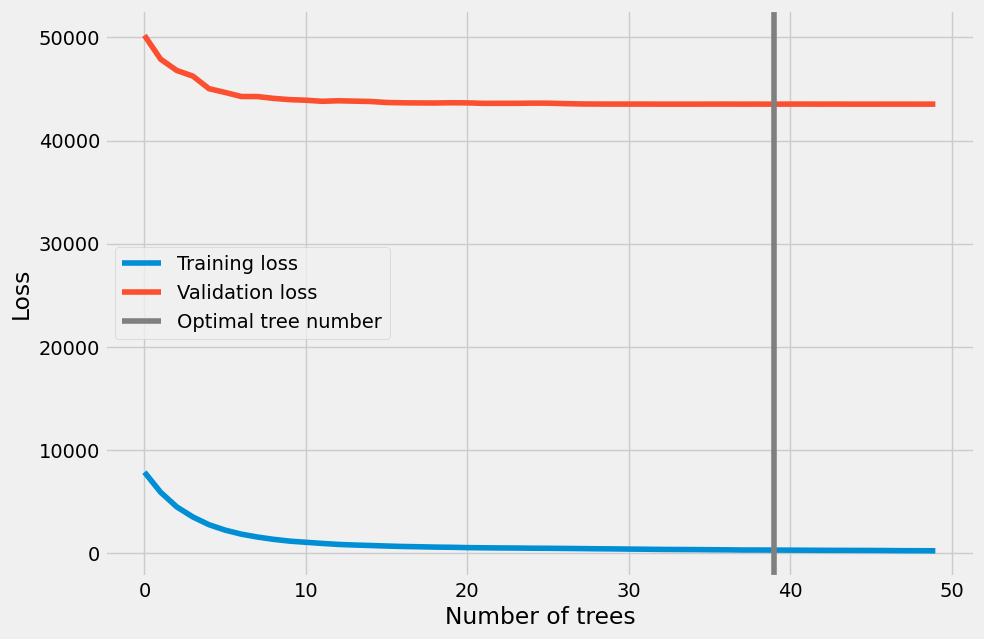

In [20]:
results = reg.evals_result()


plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(reg.best_iteration, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [21]:
reg.best_iteration

39

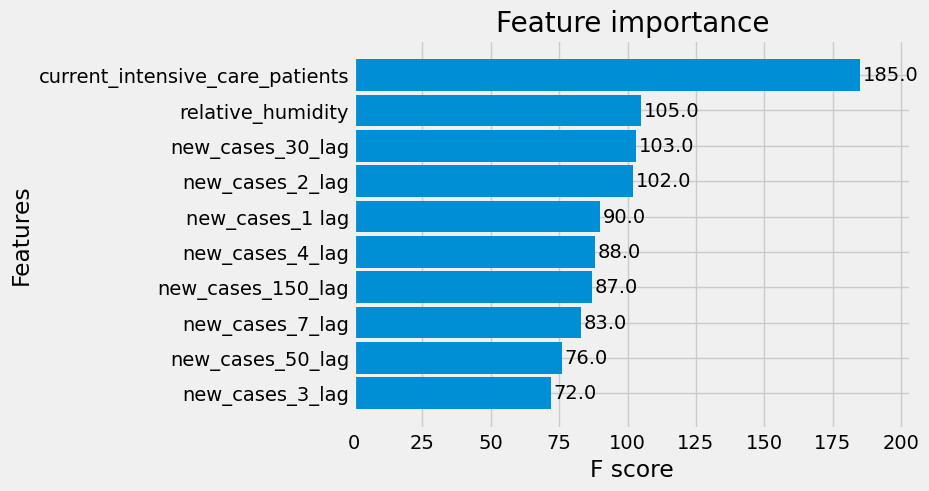

In [22]:
_ = plot_importance(reg, height=0.9 ,max_num_features = 10)

In [23]:
ca_test['MW_Prediction'] = reg.predict(X_ca_test)
full_set = pd.concat([ca_test, ca_train], sort=False)

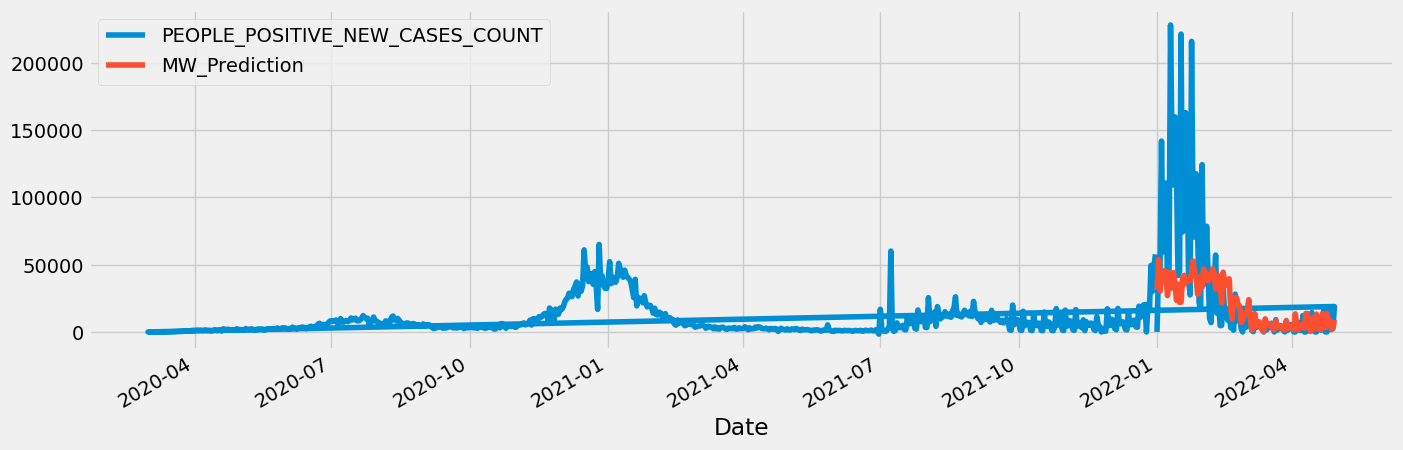

In [24]:
_ = full_set[['PEOPLE_POSITIVE_NEW_CASES_COUNT','MW_Prediction']].plot(figsize=(15, 5))

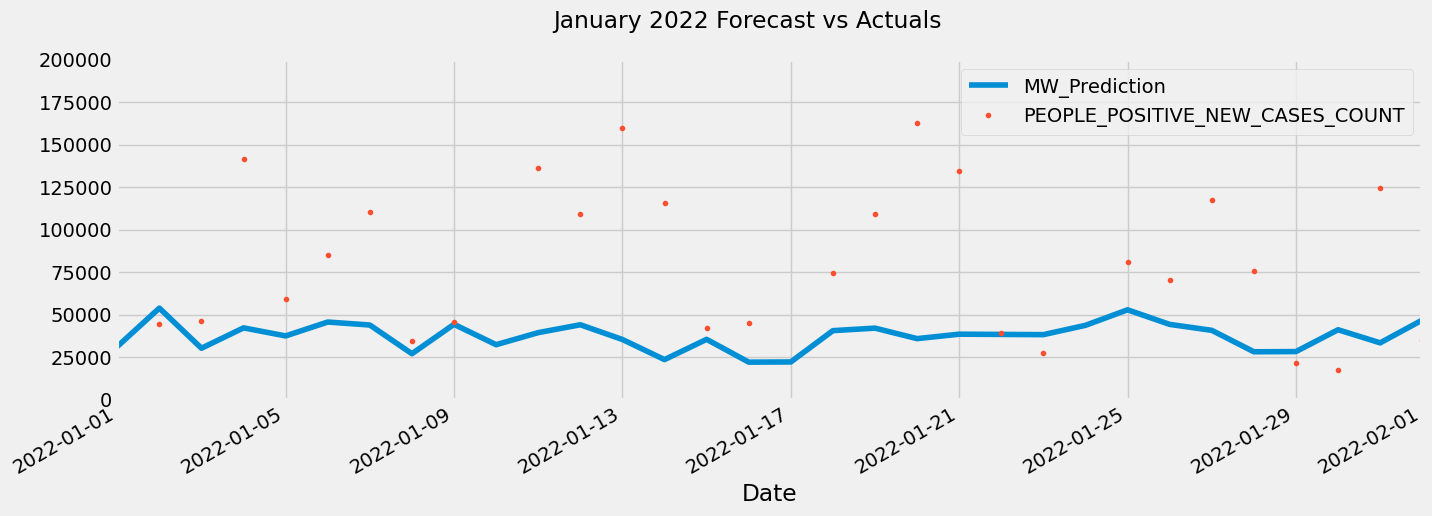

In [26]:
# look at just the first month of predictions
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = full_set[['MW_Prediction','PEOPLE_POSITIVE_NEW_CASES_COUNT']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2022', upper='02-01-2022')
ax.set_ylim(0, 200000)
plot = plt.suptitle('January 2022 Forecast vs Actuals')

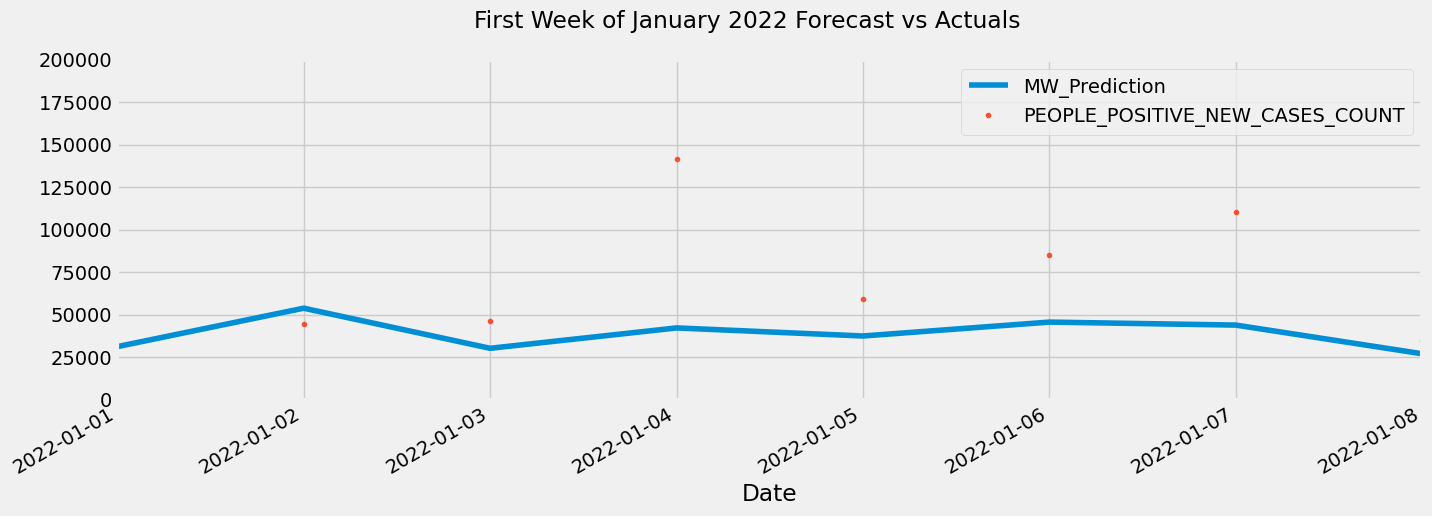

In [27]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = full_set[['MW_Prediction','PEOPLE_POSITIVE_NEW_CASES_COUNT']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2022', upper='01-08-2022')
ax.set_ylim(0, 200000)
plot = plt.suptitle('First Week of January 2022 Forecast vs Actuals')

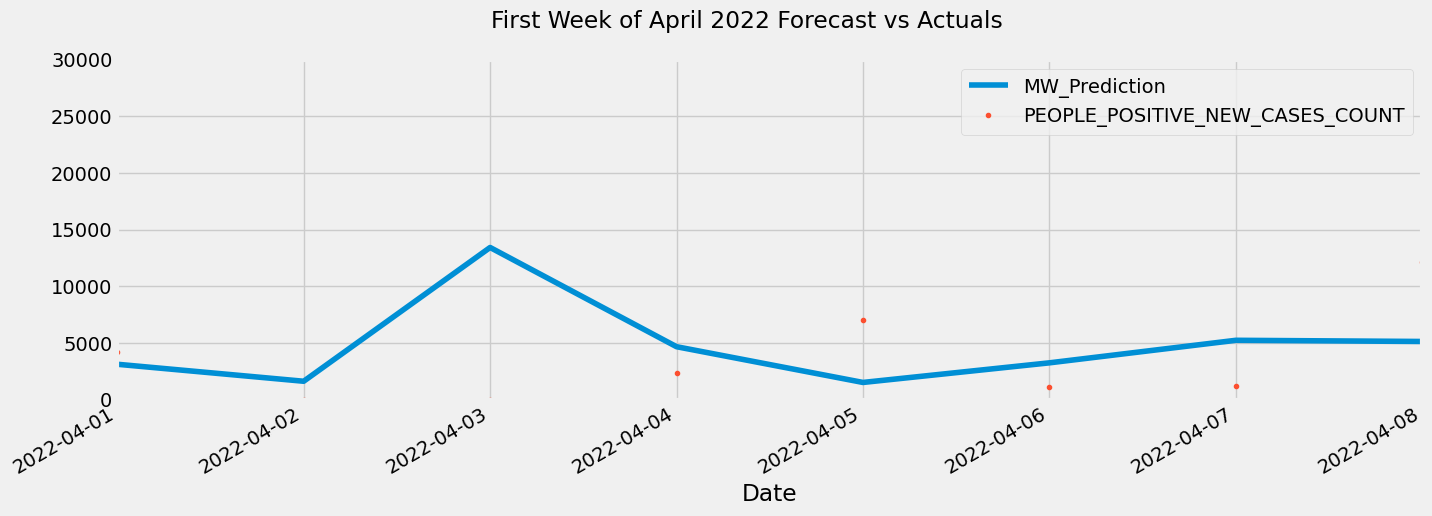

In [28]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = full_set[['MW_Prediction','PEOPLE_POSITIVE_NEW_CASES_COUNT']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 30000)
ax.set_xbound(lower='04-01-2022', upper='04-08-2022')
plot = plt.suptitle('First Week of April 2022 Forecast vs Actuals')

In [103]:
model_rmse = mean_squared_error(ca_test['PEOPLE_POSITIVE_NEW_CASES_COUNT'], ca_test['MW_Prediction'], squared=False)
model_mae = mean_absolute_error(ca_test['PEOPLE_POSITIVE_NEW_CASES_COUNT'], ca_test['MW_Prediction'])
print('Test RMSE: ', model_rmse)
print('Test MAE: ', model_mae)

Test RMSE:  40043.91279197023
Test MAE:  20281.791369782775
